In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.colors import Normalize
import seaborn as sns
import pandas as pd
import numpy as np
import math

from tensorflow.keras.models import load_model

import mdn
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

SEED=123

In [2]:
df_GG = pd.read_excel('ML_Gas_Giants20W.xlsx')
df_GG['M_total (M_E)'] = df_GG['Mcore (M_E)'] + df_GG['Menv (M_E)']

input_parameters = [
    'Mass (M_J)', 
    'Radius (R_E)',
    'T_sur (K)',
]

output_parameters = [
    'M_total (M_E)',
    'T_int (K)',
    'P_CEB (Mbar)',
    'T_CEB (K)'
]

X = df_GG[input_parameters]

y = df_GG.loc[:, output_parameters]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)



scaler_x = MinMaxScaler().fit(X_train)
scaler_y = MinMaxScaler().fit(y_train)

# from pickle import dump
# save the scaler
# dump(scaler, open('scaler.pkl', 'wb'))
X_train_scaled = scaler_x.transform(X_train)
X_test_scaled = scaler_x.transform(X_test)
y_train_scaled = scaler_y.transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

In [3]:
input_parameters = [
    'Mass (M_J)', 
    'Radius (R_E)',
    'T_sur (K)',
]

output_parameters = [
    'M_total (M_E)',
    'T_int (K)',
    'P_CEB (Mbar)',
    'T_CEB (K)'
]

# load trained model and scaler
OUTPUT_DIMS = len(output_parameters)
N_MIXES = 20
model = load_model(
    "GasGiants_MDN.h5", 
    custom_objects={"MDN": mdn.MDN(OUTPUT_DIMS, N_MIXES), "mdn_loss_func": mdn.get_mixture_loss_func(OUTPUT_DIMS,N_MIXES)},
    compile=False
)
input_scaler = joblib.load("GasGiants_MDN_INPUT_scaler.save")
output_scaler = joblib.load("GasGiants_MDN_OUTPUT_scaler.save")

## Predict Jupiter (for example)

In [4]:
# Jupiter
# input mass and radius for predicting must be Jupiter and Earth units
input_array_jupiter = np.array(
    [
        [1, 1, 1], # mass (J)
        [10.975, 10.975, 10.975], # radius (E)
        [160, 165, 170], # surface temperature 
    ]
)
scaled_input = input_scaler.transform(input_array_jupiter.T)

In [5]:
pred = model.predict(scaled_input)
# pred contains parameters for distributions, not actual points on the graph.
#print(pred)
print(pred.shape)

(3, 180)


In [6]:
colors = [
    "steelblue",
    "#EA7D1A",
    "red", 
    "gold", 
]
predict_label = [
    "Heavy-element mass (M⊕)", 
    "Intrinsic temperature (K)",
    "CEB pressure (Mbar)", 
    "CEB temperature (K)", 
]

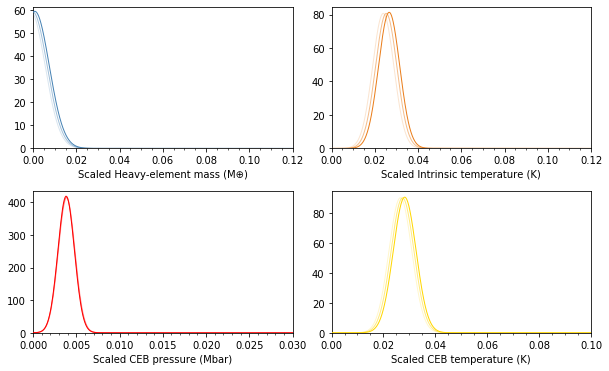

In [7]:
y_label = np.arange(0,1,0.0001).reshape(-1,1)
fig, ax = plt.subplots(2,2,figsize=(10,6))
fig.subplots_adjust(hspace=0.3, wspace=0.15)

y_min1 = min(y_test[output_parameters[0]])
y_max1 = max(y_test[output_parameters[0]])
y_min3 = min(y_test[output_parameters[2]])
y_max3 = max(y_test[output_parameters[2]])
x_max = [
    0.12,
    0.12,
    0.03,
    0.1
]
line_t = [0.2, 0.5, 1.0]
for f in range(0,3):
    pred_a = np.array([pred[f]])
    # split up the mixture parameters
    mus = np.apply_along_axis((lambda a: a[:N_MIXES*OUTPUT_DIMS]), 1, pred_a)
    sigs = np.apply_along_axis((lambda a: a[N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]), 1, pred_a)
    pis = np.apply_along_axis((lambda a: mdn.softmax(a[-N_MIXES:])), 1, pred_a)
    
    for m in range(OUTPUT_DIMS):
        locals()['mus'+str(m)] = []
        locals()['sigs'+str(m)] = []
    #    print(m)
        for n in range(20):
    #         print(n)
            locals()['mus'+str(m)].append(mus[0][n*OUTPUT_DIMS + m])
            locals()['sigs'+str(m)].append(sigs[0][n*OUTPUT_DIMS + m])
            
    for i, ax in enumerate(fig.axes):
        mus_ = np.array(locals()['mus'+str(i)])
        sigs_ = np.array(locals()['sigs'+str(i)])
        factors = 1 / math.sqrt(2*math.pi) / sigs_
        exponent = np.exp(-1/2*np.square((y_label-mus_)/sigs_))
        GMM_PDF = np.sum(pis[0]*factors*exponent, axis=1); # 对多个高斯分布求和
        ax.plot(
            y_label, 
            GMM_PDF,
            color=colors[i],
    #         label=label,
            lw=1,
            alpha=line_t[f],
            zorder=10,
        )
        ax.set_xlim(0, x_max[i])
        ax.set_ylim(bottom=0)
        ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
        ax.set_xlabel('Scaled ' + predict_label[i])
#plt.savefig('Jupiter20211003.pdf')

C:\Users\zy\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\zy\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\zy\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an 

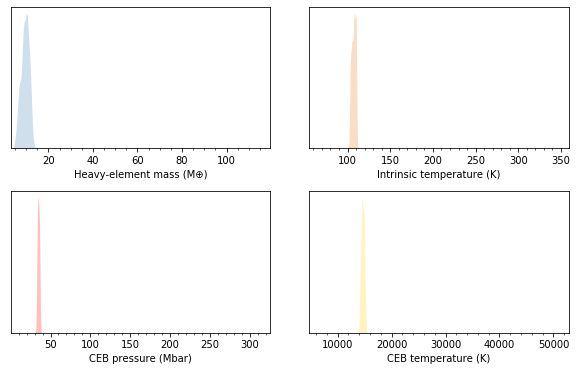

In [8]:
df_hist = pd.read_excel('applied_data.xlsx', sheet_name='Jupiter')

fig = plt.figure(figsize=(10,6))
fig.subplots_adjust(hspace=0.3, wspace=0.15)

y_min1 = min(y_test[output_parameters[0]])
y_max1 = max(y_test[output_parameters[0]])
y_min2 = min(y_test[output_parameters[1]])
y_max2 = max(y_test[output_parameters[1]])
y_min3 = min(y_test[output_parameters[2]])
y_max3 = max(y_test[output_parameters[2]])
y_min4 = min(y_test[output_parameters[3]])
y_max4 = max(y_test[output_parameters[3]])
x_max = [
    y_min1+(y_max1-y_min1)*0.12,
    y_min2+(y_max2-y_min2)*0.12,
    y_min3+(y_max3-y_min3)*0.03,
    y_min4+(y_max4-y_min4)*0.1,
]
for f in range(0,4):
    ax = fig.add_subplot(2, 2, f+1)
    y_min =min(y_test[output_parameters[f]])
    sns.distplot(
        df_hist[output_parameters[f]], 
        bins=20,
        color=colors[f],
#         alpha=0.8,
#         edgecolor="w", 
        
#         linewidth=1,
        kde=True,
        hist=False,
        kde_kws=dict(
#          bw=0.1, 
           shade=True, 
           linewidth=0
        )
    )
    ax.set_xlim(y_min, x_max[f])
    ax.set_ylim(bottom=0)
    ax.set_yticks([])
    ax.set_ylabel(None)
    ax.set_xlabel(predict_label[f])
    ax.xaxis.set_minor_locator(AutoMinorLocator())
#plt.savefig('Jupiter_model.pdf')

## Predict CoRoT-6b (for example)

In [9]:
input_array_6b = np.array(
    [
        [2.96], # mass Jupiter units
        [13.068], # radius Earth units
        [1017], # surface temperature k
    ]
)
scaled_input = input_scaler.transform(input_array_6b.T)

In [10]:
pred = model.predict(scaled_input)
# pred contains parameters for distributions, not actual points on the graph.
#print(pred)
print(pred.shape)

(1, 180)


In [11]:
# split up the mixture parameters
mus = np.apply_along_axis((lambda a: a[:N_MIXES*OUTPUT_DIMS]), 1, pred)
sigs = np.apply_along_axis((lambda a: a[N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]), 1, pred)
pis = np.apply_along_axis((lambda a: mdn.softmax(a[-N_MIXES:])), 1, pred)

for m in range(OUTPUT_DIMS):
    locals()['mus'+str(m)] = []
    locals()['sigs'+str(m)] = []
#    print(m)
    for n in range(20):
#         print(n)
        locals()['mus'+str(m)].append(mus[0][n*OUTPUT_DIMS + m])
        locals()['sigs'+str(m)].append(sigs[0][n*OUTPUT_DIMS + m])

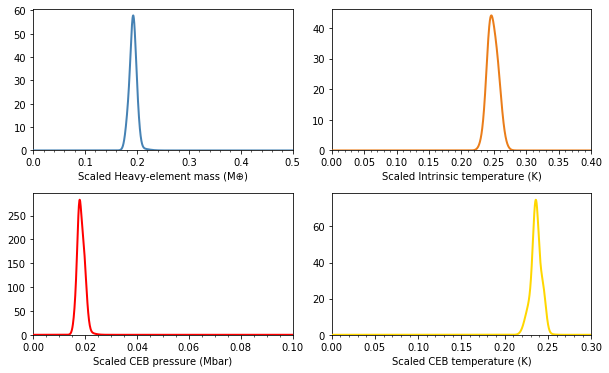

In [12]:
y_label = np.arange(0,1,0.0001).reshape(-1,1)
fig, ax = plt.subplots(2,2,figsize=(10,6))
fig.subplots_adjust(hspace=0.3, wspace=0.15)

y_min1 = min(y_test[output_parameters[0]])
y_max1 = max(y_test[output_parameters[0]])
y_min3 = min(y_test[output_parameters[2]])
y_max3 = max(y_test[output_parameters[2]])
x_max = [
    0.5,
    0.4,
    0.1,
    0.3
]
# fig.subplots_adjust(hspace=0.3, wspace=0.1)
for i, ax in enumerate(fig.axes):
    mus_ = np.array(locals()['mus'+str(i)])
    sigs_ = np.array(locals()['sigs'+str(i)])
    factors = 1 / math.sqrt(2*math.pi) / sigs_
    exponent = np.exp(-1/2*np.square((y_label-mus_)/sigs_))
    GMM_PDF = np.sum(pis[0]*factors*exponent, axis=1); # 对多个高斯分布求和
    ax.plot(
        y_label, 
        GMM_PDF,
        color=colors[i],
#         label=label,
        lw=2,
        zorder=10,
    )
    ax.set_xlim(0, x_max[i])
    ax.set_ylim(bottom=0)
#     ax.set_yticks([])
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.set_xlabel('Scaled ' + predict_label[i])
#plt.savefig('CoToR_6b_20210923.pdf')

C:\Users\zy\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\zy\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\zy\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an 

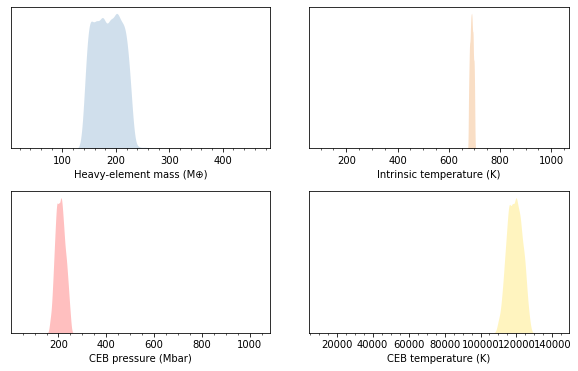

In [13]:
df_hist = pd.read_excel('applied_data.xlsx', sheet_name='CoRoT6b')

fig = plt.figure(figsize=(10,6))
fig.subplots_adjust(hspace=0.3, wspace=0.15)

y_min1 = min(y_test[output_parameters[0]])
y_max1 = max(y_test[output_parameters[0]])
y_min2 = min(y_test[output_parameters[1]])
y_max2 = max(y_test[output_parameters[1]])
y_min3 = min(y_test[output_parameters[2]])
y_max3 = max(y_test[output_parameters[2]])
y_min4 = min(y_test[output_parameters[3]])
y_max4 = max(y_test[output_parameters[3]])
x_max = [
    y_min1+(y_max1-y_min1)*0.5,
    y_min2+(y_max2-y_min2)*0.4,
    y_min3+(y_max3-y_min3)*0.1,
    y_min4+(y_max4-y_min4)*0.3,
]

for f in range(0,4):
    ax = fig.add_subplot(2, 2, f+1)
    y_min =min(y_test[output_parameters[f]])
    sns.distplot(
        df_hist[output_parameters[f]], 
#         bins=100,
        color=colors[f],
#         alpha=0.8,
#         edgecolor="w", 
        
#         linewidth=1,
        kde=True,
        hist=False,
        kde_kws=dict(
#             bw=0.1, 
            shade=True, 
            linewidth=0,
            bw_adjust=1
        )
    )
    ax.set_xlim(y_min, x_max[f])
    ax.set_ylim(bottom=0)
    ax.set_yticks([])
    ax.set_ylabel(None)
    ax.set_xlabel(predict_label[f])
    ax.xaxis.set_minor_locator(AutoMinorLocator())
#plt.savefig('CoRoT6b_model.pdf')